In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q pytorch-lightning pytorch-forecasting xgboost numdifftools optuna imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os

training_duration = 17280 # 12 month
validation_duration = 864 # 3 days
testing_duration =  4032*10 #2 weeks
test_offset = 20000
train_offset = test_offset - training_duration
smoothing_threshold = 50
sliding_window_size = 30
prediction_window = 2
classification_label_size = 12
trend_measure_lenth = 12
include_google_trend = False
google_trend_length = sliding_window_size
base_folder         = "/content/drive/MyDrive/tft/"
model_save_folder   = base_folder + f"classifier/model-{sliding_window_size}-{prediction_window}-GT-{include_google_trend}"  # folder to save checkpoints
tft_model_path      = base_folder + f"model-{sliding_window_size}-{prediction_window}-{test_offset/1000}K/best_tft.ckpt"

# ensure save directory exists
os.makedirs(model_save_folder, exist_ok=True)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
from torch.autograd import Variable

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
import torchmetrics
import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
import numdifftools as nd
from scipy.signal import argrelextrema
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import ADASYN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df=pd.read_csv("/content/drive/MyDrive/tft/data/new/df_with_trends_5m.csv")
df.head()

,timestamp,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,...,pca17,pca18,pca19,pca20,pca21,close,Bitcoin,Bitcoin price,Bitcoin dip,Buy Bitcoin
0,2023-05-01 18:25:00,-4.728668,-1.114607,-0.365115,0.485136,0.384824,1.576102,1.213044,0.924503,0.821012,...,0.312060,1.402576,1.568977,0.565268,0.149354,28212.73,71.75,81.166667,0.0,80.333333
1,2023-05-01 18:30:00,-4.634006,-2.731459,1.695327,-2.316193,-0.782514,0.937458,1.450889,0.243998,-1.020911,...,0.060306,1.301197,1.825314,-0.126535,0.037677,28127.82,72.50,82.000000,0.0,81.000000
2,2023-05-01 18:35:00,-4.696686,-1.201332,0.447267,1.522653,0.018328,0.077646,-1.386036,-1.748878,0.032070,...,0.696833,1.348496,1.671811,0.304412,0.202355,28169.00,73.25,82.833333,0.0,81.666667
3,2023-05-01 18:40:00,-4.711780,-2.333551,0.040513,-0.850880,0.054831,-1.126004,2.241217,-1.532337,-0.500323,...,0.286385,1.370392,1.611524,0.443190,0.128267,28128.59,74.00,83.666667,0.0,82.333333
4,2023-05-01 18:45:00,-4.715642,-1.501571,0.141052,1.013131,0.073797,1.087630,0.091214,-0.375504,0.322662,...,0.552559,1.358777,1.638289,0.411483,0.193431,28150.00,74.75,84.500000,0.0,83.000000


In [6]:
print(df.shape)

(210485, 23)


In [7]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

print(NaNCheck(df))

Series([], dtype: int64)


In [8]:
def sliding_window(x, y, y_raw, idx, gt, feature_window, label_window, trend_window, google_trend_window):
    x_ = []
    y_ = []
    y_tft_pr = []
    y_tft_cl = []
    y_tft_tr = []
    y_tft_gt = []
    low_idx  = []
    backward_length = max(feature_window, trend_window, label_window, google_trend_window)
    for i in range(backward_length, x.shape[0]-label_window):
        tmp_x = x[i - feature_window: i, :]
        tmp_y = y[i]
        tmp_y_tft_pr = y[i - feature_window: i + 1]
        tmp_y_tft_cl = y_raw[i - label_window: i + label_window+1]
        tmp_y_tft_tr = y_raw[i - trend_window: i, :]
        tmp_y_tft_gt = gt[i - google_trend_window: i, :]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_tft_pr.append(tmp_y_tft_pr)
        y_tft_cl.append(tmp_y_tft_cl)
        y_tft_tr.append(tmp_y_tft_tr)
        y_tft_gt.append(tmp_y_tft_gt)
        low_idx.append(idx[i - feature_window])
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_tft_pr = torch.from_numpy(np.array(y_tft_pr)).float()
    y_tft_cl = torch.from_numpy(np.array(y_tft_cl)).float()
    y_tft_tr = torch.from_numpy(np.array(y_tft_tr)).float()
    y_tft_gt = torch.from_numpy(np.array(y_tft_gt)).float()
    return x_, y_, y_tft_pr, y_tft_cl, y_tft_tr, y_tft_gt, low_idx

In [9]:
def trend_detection(data):
    n = data.shape[1]
    sets = data.shape[0]
    mean_derivatives = np.zeros((sets,1))

    data = data.numpy()

    for i in range(sets):
        # Select the i-th 20 set
        x = np.arange(1,n+1)
        x_fake = np.arange(1.1, n, 0.1)
        y = data[i, :, 0]
        # Simple interpolation of x and y
        f = interp1d(x, y)

        # derivative of y with respect to x
        df_dx = nd.Derivative(f, step=1e-6)(x_fake)
        # Calculate the mean derivative for the i-th 20 set
        average = np.average(df_dx)
        mean_derivatives[i][0] = average
    return  torch.from_numpy(mean_derivatives)

In [10]:
trend_scaler = MinMaxScaler(feature_range = (0, 1))
google_trend_scaler = MinMaxScaler(feature_range = (0, 1))

labels_df = df["close"]
features_df = df.drop(columns=["close", "Bitcoin", "Bitcoin price", "Bitcoin dip", "Buy Bitcoin", "timestamp"])
google_trend_df = df[["Bitcoin price", "Buy Bitcoin"]]

train_x = features_df.iloc[train_offset:train_offset+training_duration].values
train_y = labels_df.iloc[train_offset:train_offset+training_duration]
train_gt = google_trend_df.iloc[train_offset:train_offset+training_duration].values
train_idx = df.index[train_offset:train_offset+training_duration]

st_test = test_offset
test_x = features_df.iloc[st_test:st_test+testing_duration].values
test_y = labels_df.iloc[st_test:st_test+testing_duration]
test_gt = google_trend_df.iloc[st_test:st_test+testing_duration].values
test_idx = df.index[st_test:st_test+testing_duration]

train_gt = google_trend_scaler.fit_transform(train_gt)
test_gt = google_trend_scaler.transform(test_gt)
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')
print(f'trainGT: {train_gt.shape} testGT: {test_gt.shape}')
print(f'train_idx: {train_idx.shape} test_idx: {test_idx.shape}')

trainX: (17280, 17) trainY: (17280,)
testX: (40320, 17) testY: (40320,)
trainGT: (17280, 2) testGT: (40320, 2)
train_idx: (17280,) test_idx: (40320,)


In [11]:
raw_train_y = train_y.values.reshape(-1, 1)
raw_test_y = test_y.values.reshape(-1, 1)

In [12]:
# For price prediction model
train_x_slide, train_y_slide, train_y_tft,train_y_tft_cl,train_direction_slide, train_google_trend, train_idx = sliding_window(train_x, raw_train_y, raw_train_y, train_idx, train_gt, sliding_window_size, classification_label_size, trend_measure_lenth, google_trend_length)
test_x_slide, test_y_slide, test_y_tft,test_y_tft_cl,test_direction_slide, test_google_trend, test_idx = sliding_window(test_x, raw_test_y, raw_test_y, test_idx, test_gt, sliding_window_size, classification_label_size, trend_measure_lenth, google_trend_length)

train_trend_features = trend_detection(train_direction_slide)
test_trend_features = trend_detection(test_direction_slide)
train_trend_features = torch.tensor(trend_scaler.fit_transform(train_trend_features))
test_trend_features = torch.tensor(trend_scaler.transform(test_trend_features))
new_feature_tensor_train = train_trend_features.repeat(1,sliding_window_size)
new_feature_tensor_train = new_feature_tensor_train.unsqueeze(2)
new_feature_tensor_test = test_trend_features.repeat(1,sliding_window_size)
new_feature_tensor_test = new_feature_tensor_test.unsqueeze(2)

print('For Price prediction')
print(f'train_x_slide: {train_x_slide.shape} train_y_slide: {train_y_slide.shape} train_y_gan: {train_y_tft.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_slide: {test_y_slide.shape} test_y_gan: {test_y_tft.shape}\n')

print('For Bottom classification')
print(f'train_x_slide: {train_x_slide.shape} train_y_gan_cl: {train_y_tft_cl.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_gan_cl: {test_y_tft_cl.shape}\n')

print('For current trend calculation')
print(f'train_direction_slide: {train_direction_slide.shape} train_trend_features: {train_trend_features.shape} ')
print(f'test_direction_slide: {test_direction_slide.shape} test_trend_features: {test_trend_features.shape} ')

For Price prediction
train_x_slide: torch.Size([17238, 30, 17]) train_y_slide: torch.Size([17238, 1]) train_y_gan: torch.Size([17238, 31, 1])
test_x_slide: torch.Size([40278, 30, 17]) test_y_slide: torch.Size([40278, 1]) test_y_gan: torch.Size([40278, 31, 1])

For Bottom classification
train_x_slide: torch.Size([17238, 30, 17]) train_y_gan_cl: torch.Size([17238, 25, 1])
test_x_slide: torch.Size([40278, 30, 17]) test_y_gan_cl: torch.Size([40278, 25, 1])

For current trend calculation
train_direction_slide: torch.Size([17238, 12, 1]) train_trend_features: torch.Size([17238, 1]) 
test_direction_slide: torch.Size([40278, 12, 1]) test_trend_features: torch.Size([40278, 1]) 


In [13]:
def find_bottom_point_labels_mean(y,slide):

    y1 = y[:, :slide, :] # 128,10,1
    y2 = y[:, slide+1:, :]
    values = y[:,slide,:]

    y_avg = torch.mean(y1,dim=1)
    y_next_avg = torch.mean(y2, dim=1)
    y_bool = y_avg>(y[:,slide,:] + smoothing_threshold)
    y_next_bool = y_next_avg>(y[:,slide,:] + smoothing_threshold)
    result = np.logical_and(y_bool.numpy(), y_next_bool.numpy())
    y_label=np.where(result, 1, 0)

    index_val = np.where(y_label == 1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=(15, 8))
    plt.plot(y[:,slide,:], zorder=0)
    plt.scatter(index_val[0], values[np.where(y_label == 1)],
      label='Minima', s=100, color=colors[1], marker='^')
    plt.legend()
    plt.show()

    y_labels = torch.from_numpy(y_label)

    return y_labels

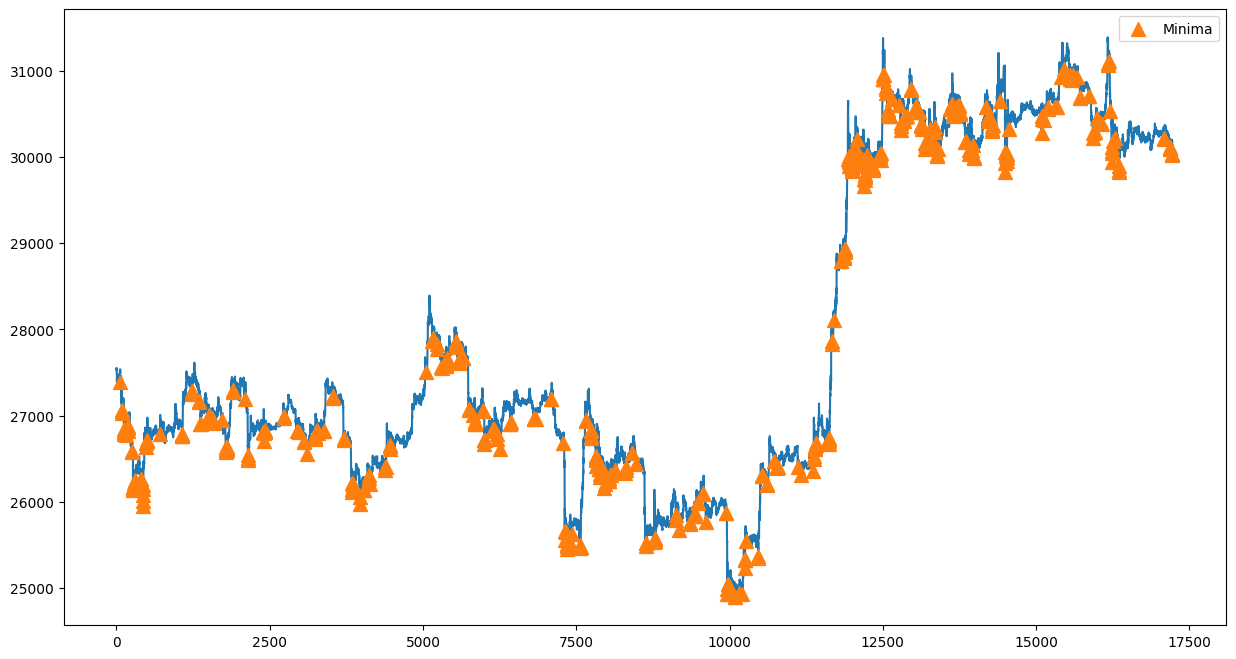

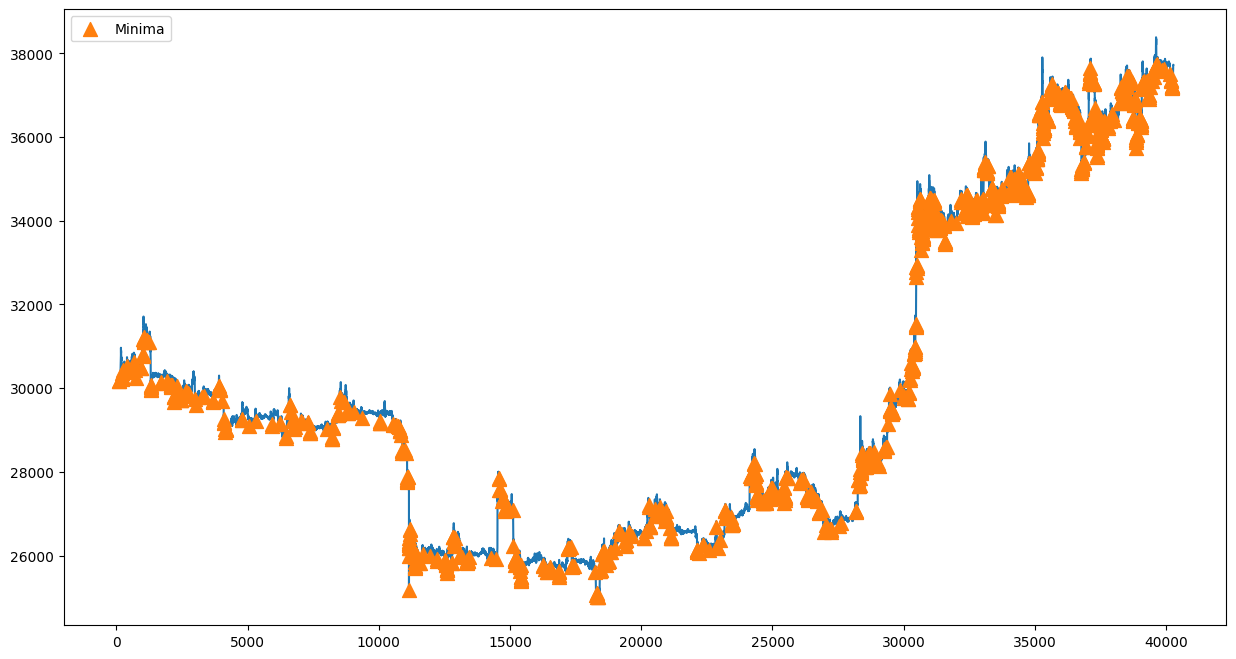

[16743   495]
[39039  1239]
33.82424242424243


In [14]:
def calc_labels(labels):
    unique_labels = torch.unique(labels)
    unique_labels, label_counts = np.unique(labels.numpy(), return_counts=True)
    return label_counts

train_bottoms = find_bottom_point_labels_mean(train_y_tft_cl,classification_label_size)
test_bottoms = find_bottom_point_labels_mean(test_y_tft_cl,classification_label_size)
train_bottom_count = calc_labels(train_bottoms)
test_bottom_count = calc_labels(test_bottoms)
print(train_bottom_count)
print(test_bottom_count)
print(train_bottom_count[0]/train_bottom_count[1])

In [15]:
def load_tft_strict_cpu(checkpoint_path: str) -> TemporalFusionTransformer:
    """
    Load a TFT Lightning checkpoint strictly on CPU.
    Avoids any .cpu() calls that trigger torchmetrics CUDA init.
    """
    # 1) Load full checkpoint (allow unpickle) onto CPU
    ckpt = torch.load(
        checkpoint_path,
        map_location=torch.device("cpu"),
        weights_only=False
    )
    # 2) Extract Lightning hyperparameters
    hparams = ckpt.get("hyper_parameters", ckpt.get("hparams", {}))
    # 3) Instantiate fresh TFT on CPU (no GPUs involved)
    model = TemporalFusionTransformer(**hparams)
    # 4) Load weights & buffers (already on CPU)
    model.load_state_dict(ckpt["state_dict"])
    # 5) Patch every torchmetrics.Metric to live on CPU
    for module in model.modules():
        if isinstance(module, torchmetrics.Metric):
            module._device = torch.device("cpu")
    # 6) Set to inference mode (no further .cpu needed)
    model.eval()
    return model

In [16]:
pca_columns = [c for c in df.columns if c.startswith("pca")]

train_df = df.iloc[:test_offset].copy()
train_df["time_idx"] = train_df.index
train_df["series"]   = "BTC"
target_normalizer = GroupNormalizer(
    groups=["series"],
    transformation="log",       # learn in log space, invert with exp
    )
train_dataset = TimeSeriesDataSet(
        train_df,
        time_idx="time_idx",
        target="close",
        group_ids=["series"],
        min_encoder_length=sliding_window_size,
        max_encoder_length=sliding_window_size,
        min_prediction_length=prediction_window,
        max_prediction_length=prediction_window,
        static_categoricals=["series"],
        time_varying_known_reals=["time_idx"] + pca_columns,
        time_varying_unknown_reals=["close"],
        target_normalizer=target_normalizer,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
    )

In [17]:
def infer_attention_batch(
    model: TemporalFusionTransformer,
    look_back: int,
    prediction_length: int,
    df: pd.DataFrame,
):
    dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    df,
    predict=False,
    stop_randomization=True
)
    dl = dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

    enc_lstm_list = []
    post_lstm_enc_list = []

    def lstm_enc_hook(module, inp, out):
        enc_lstm_list.append(out[0].detach())          # [B, enc_len, H]

    def post_lstm_hook(module, inp, out):
        # Keep only encoder-length outputs
        if out.size(1) == look_back:
            post_lstm_enc_list.append(out.detach())    # [B, enc_len, H]

    h1 = model.lstm_encoder.register_forward_hook(lstm_enc_hook)
    h2 = model.post_lstm_add_norm_encoder.register_forward_hook(post_lstm_hook)

    try:
        raw = model.predict(dl, mode="raw")
    finally:
        h1.remove(); h2.remove()

    encoder_attention = raw["encoder_attention"].cpu()
    decoder_attention = raw["decoder_attention"].cpu()
    prediction        = raw["prediction"].cpu()

    enc_lstm_seq  = torch.cat(enc_lstm_list, dim=0).cpu()          # [N, enc_len, H]
    post_lstm_seq = torch.cat(post_lstm_enc_list, dim=0).cpu()     # aligned shapes

    return encoder_attention, decoder_attention, prediction, enc_lstm_seq, post_lstm_seq


In [18]:
def get_intermediate_weights(x_idx, df_int):
  model = load_tft_strict_cpu(tft_model_path)
  lower_idx = min(x_idx)
  upper_idx = max(x_idx) + sliding_window_size + prediction_window
  row_slice = slice(lower_idx, upper_idx)
  chunk = df_int[row_slice]
  chunk["time_idx"] = chunk.index
  chunk["series"]   = "BTC"
  enc_attn, dec_attn, pred_1, enc_lstm_seq, post_lstm_seq = infer_attention_batch(
        model,
        sliding_window_size,                # shape (n, look_back, num_features)
        prediction_window,
        chunk
    )
  return post_lstm_seq, pred_1

In [19]:
spw = train_bottom_count[0]/train_bottom_count[1]
device = 'cpu'

def xgboost_train(x,y,eta=0.1):
    x = x.reshape(x.shape[0], -1)
    adasyn = ADASYN(sampling_strategy=0.3, random_state=42)
    x, y = adasyn.fit_resample(x.detach().cpu().numpy(), y.detach().cpu().numpy())
    model= xgb.XGBClassifier(
        n_estimators=700,
        max_depth=7,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric='aucpr',
        subsample = 0.1,
        colsample_bytree = 0.15,
        min_child_weight= 15,
        reg_alpha=0.7,
    )
    model.fit(x,y)
    return model

def xgboost_test(x, y, xgmodel):
    tft_seq_xg = x.reshape(x.shape[0], -1)
    pred = xgmodel.predict(tft_seq_xg.detach().cpu().numpy())
    pred = torch.tensor(pred).reshape(pred.shape[0],1)
    return pred,y

In [20]:
import numpy as np
import torch
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import xgboost as xgb

try:
    import optuna
except ImportError:
    optuna = None

def xgboost_train_weighted(
        x: torch.Tensor,
        y: torch.Tensor,
        random_state: int = 42,
        use_optuna: bool = True,
        n_optuna_trials: int = 40,
        gpu: bool = True,
        multi_gpu: bool = False,
        early_stopping_rounds: int = 50,
        base_n_estimators: int = 1200,
        min_delta: float = 0.0,   # kept for API symmetry; not used by constructor ES
        log_level: int = logging.INFO,
        verbose_model: int = 0
    ):
    """
    Train an XGBoost model with class weighting (scale_pos_weight), optional Optuna tuning,
    and constructor-based early stopping (robust against callback best_iteration bug).
    Returns (model, best_params_dict).
    """

    logging.basicConfig(level=log_level, format='[%(asctime)s] %(levelname)s: %(message)s')
    logger = logging.getLogger("xgb_train")

    logger.info("Starting weighted XGBoost training (constructor early stopping).")

    # -------- Data --------
    X = x.reshape(x.shape[0], -1).detach().cpu().numpy()
    Y = y.detach().cpu().numpy()

    # Stratified split to preserve minority class in validation
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, Y, test_size=0.2, stratify=Y, random_state=random_state
    )

    # Check validation contains both classes
    if len(np.unique(y_valid)) < 2:
        raise ValueError("Validation set has only one class; adjust split or use larger dataset for early stopping.")

    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    scale_pos_weight = n_neg / max(1, n_pos)
    logger.info(f"Train class distribution: pos={n_pos}, neg={n_neg}, scale_pos_weight={scale_pos_weight:.3f}")

    tree_method = 'gpu_hist' if gpu else 'hist'
    params_base = dict(
        objective='binary:logistic',
        eval_metric='aucpr',
        tree_method=tree_method,
        random_state=random_state,
        scale_pos_weight=scale_pos_weight,
        verbosity=verbose_model,
        early_stopping_rounds=early_stopping_rounds
    )
    if gpu and multi_gpu:
        params_base["n_gpus"] = -1
        logger.info("Multi-GPU enabled (n_gpus=-1).")

    default_space = dict(
        max_depth=6,
        min_child_weight=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=2.0,
        gamma=0.0,
        n_estimators=base_n_estimators
    )

    def fit_and_score(model_params, label="model"):
        clf = xgb.XGBClassifier(**model_params)
        clf.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
        y_pred = clf.predict_proba(X_valid)[:, 1]
        ap = average_precision_score(y_valid, y_pred)

        # Safe best_iteration extraction (may not exist if no early stop triggered)
        if hasattr(clf, "best_iteration"):
            best_iter = int(clf.best_iteration)
            stopped_early = True
        else:
            best_iter = clf.get_booster().num_boosted_rounds() - 1
            stopped_early = False
        logger.info(f"{label}: AP={ap:.5f} best_iter={best_iter} early_stopped={stopped_early}")
        return clf, ap, best_iter, stopped_early

    best_model = None
    best_params_report = {}
    best_score = -np.inf

    if use_optuna and optuna is not None:
        logger.info(f"Optuna search: {n_optuna_trials} trials.")

        def objective(trial):
            trial_params = {
                "max_depth": trial.suggest_int("max_depth", 3, 9),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
                "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 10.0, log=True),
                "gamma": trial.suggest_float("gamma", 0.0, 3.0),
                "n_estimators": trial.suggest_int("n_estimators", 400, 1800)
            }
            params = {**params_base, **trial_params}
            clf, ap, best_iter, stopped = fit_and_score(params, label=f"trial {trial.number}")
            trial.set_user_attr("best_iteration", best_iter)
            trial.set_user_attr("early_stopped", stopped)
            return ap

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_optuna_trials, show_progress_bar=False)
        logger.info(f"Optuna best trial {study.best_trial.number} AP={study.best_value:.5f}")

        refit_params = {**params_base, **study.best_trial.params}
        best_model, best_score, best_iter, stopped = fit_and_score(refit_params, label="refit best")

        best_params_report = {
            **refit_params,
            "scale_pos_weight": scale_pos_weight,
            "best_iteration": best_iter,
            "early_stopped": stopped,
            "best_score_valid_aucpr": float(best_score),
            "optuna_best_trial": study.best_trial.number
        }
    else:
        if use_optuna and optuna is None:
            logging.warning("Optuna not installed; using default parameters.")
        base_params = {**params_base, **default_space}
        best_model, best_score, best_iter, stopped = fit_and_score(base_params, label="baseline")
        best_params_report = {
            **base_params,
            "scale_pos_weight": scale_pos_weight,
            "best_iteration": best_iter,
            "early_stopped": stopped,
            "best_score_valid_aucpr": float(best_score),
            "optuna_best_trial": None
        }

    logger.info(f"Done. Validation AP={best_score:.5f}; early_stopped={best_params_report['early_stopped']}")
    return best_model, best_params_report


In [21]:
# learning_rate_xgboost2 = 0.3
print(train_x_slide.size())
train_input_features, pred_train = get_intermediate_weights(train_idx, df)
print("train_input_features:", train_input_features.size())
print("new_feature_tensor_train:", new_feature_tensor_train.size())
print("train_google_trend:", train_google_trend.size())
train_input_features = torch.cat((train_input_features, new_feature_tensor_train), dim=2)
if (include_google_trend):
  train_input_features = torch.cat((train_input_features, train_google_trend), dim=2)
xgb_model, best_params_report = xgboost_train_weighted(train_input_features,train_bottoms)

pred_direction_train,true_direction_train = xgboost_test(train_input_features,train_bottoms,xgb_model)
pred_direction_train = torch.round(pred_direction_train).long()
f1_score_val_train =  f1_score(train_bottoms.numpy(), pred_direction_train.numpy())
precision_score_val_train = precision_score(train_bottoms.numpy(), pred_direction_train.numpy(),zero_division=0)
recall_score_train = recall_score(train_bottoms.numpy(), pred_direction_train.numpy(), average='micro')

test_input_features, pred_test = get_intermediate_weights(test_idx, df)
test_input_features = torch.cat((test_input_features, new_feature_tensor_test), dim=2)
if (include_google_trend):
  test_input_features = torch.cat((test_input_features, test_google_trend), dim=2)
pred_direction_test,true_direction_test = xgboost_test(test_input_features,test_bottoms,xgb_model)
pred_direction_test = torch.round(pred_direction_test).long()
f1_score_val_test = f1_score(test_bottoms.numpy(), pred_direction_test.numpy())
precision_score_val_test = precision_score(test_bottoms.numpy(), pred_direction_test.numpy(),zero_division=0)
recall_score_test = recall_score(test_bottoms.numpy(), pred_direction_test.numpy(), average='micro')

print("F1_score_train:", f1_score_val_train)
print("Precision_train: ",precision_score_val_train)
print("Recall_train: ",recall_score_train)
print("F1_score_test:", f1_score_val_test)
print("Precision_test: ",precision_score_val_test)
print("Recall_test: ",recall_score_test)

print("pred_train:", pred_train[:10])
print("pred_test:", pred_test[:10])

torch.Size([17238, 30, 17])


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

train_input_features: torch.Size([17238, 30, 32])
new_feature_tensor_train: torch.Size([17238, 30, 1])
train_google_trend: torch.Size([17238, 30, 2])


[I 2025-07-21 13:57:43,563] A new study created in memory with name: no-name-f23a9e05-4d91-44c3-9600-65ce98de1613
[I 2025-07-21 13:57:48,442] Trial 0 finished with value: 0.2688845299711786 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.05669743443878088, 'subsample': 0.9737041035446738, 'colsample_bytree': 0.5429756899814366, 'reg_alpha': 0.0016779969817425956, 'reg_lambda': 7.366332869859136, 'gamma': 2.642049795317629, 'n_estimators': 1348}. Best is trial 0 with value: 0.2688845299711786.
[I 2025-07-21 13:57:53,346] Trial 1 finished with value: 0.24798625407727307 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'learning_rate': 0.027956743406641858, 'subsample': 0.7192100594221422, 'colsample_bytree': 0.917650944223574, 'reg_alpha': 0.8820941398399048, 'reg_lambda': 1.2398199598899728, 'gamma': 1.1422155104666745, 'n_estimators': 772}. Best is trial 0 with value: 0.2688845299711786.
[I 2025-07-21 13:57:59,839] Trial 2 finished with value: 0.231766

F1_score_train: 0.8301886792452831
Precision_train:  0.7787610619469026
Recall_train:  0.9895579533588583
F1_score_test: 0.07591240875912408
Precision_test:  0.054336468129571575
Recall_test:  0.9057053478325637
pred_train: tensor([[[27500.3066, 27524.9434, 27565.8203],
         [27487.4570, 27514.4727, 27558.5391]],

        [[27501.3027, 27525.2324, 27565.9512],
         [27510.6934, 27542.3789, 27587.5176]],

        [[27521.3750, 27549.4199, 27591.0156],
         [27482.0840, 27508.3066, 27553.1230]],

        [[27509.7754, 27533.0293, 27574.3379],
         [27484.2598, 27510.1172, 27554.8066]],

        [[27501.4609, 27524.2617, 27565.4512],
         [27463.7969, 27486.8809, 27531.8223]],

        [[27486.8809, 27507.4688, 27548.9980],
         [27450.4707, 27474.3281, 27521.8730]],

        [[27466.3633, 27487.5371, 27531.4277],
         [27403.9629, 27425.7148, 27476.0312]],

        [[27430.3711, 27449.9707, 27496.5566],
         [27337.1914, 27366.8496, 27428.4883]],

        

In [22]:
best_params_report

{'objective': 'binary:logistic',
 'eval_metric': 'aucpr',
 'tree_method': 'gpu_hist',
 'random_state': 42,
 'scale_pos_weight': np.float64(33.823232323232325),
 'verbosity': 0,
 'early_stopping_rounds': 50,
 'max_depth': 9,
 'min_child_weight': 13,
 'learning_rate': 0.04266462023425686,
 'subsample': 0.5621629657414986,
 'colsample_bytree': 0.6587249602860401,
 'reg_alpha': 0.001416355584766934,
 'reg_lambda': 1.8155632289288641,
 'gamma': 0.4001103495623083,
 'n_estimators': 1021,
 'best_iteration': 501,
 'early_stopped': True,
 'best_score_valid_aucpr': 0.3353074475452208,
 'optuna_best_trial': 18}

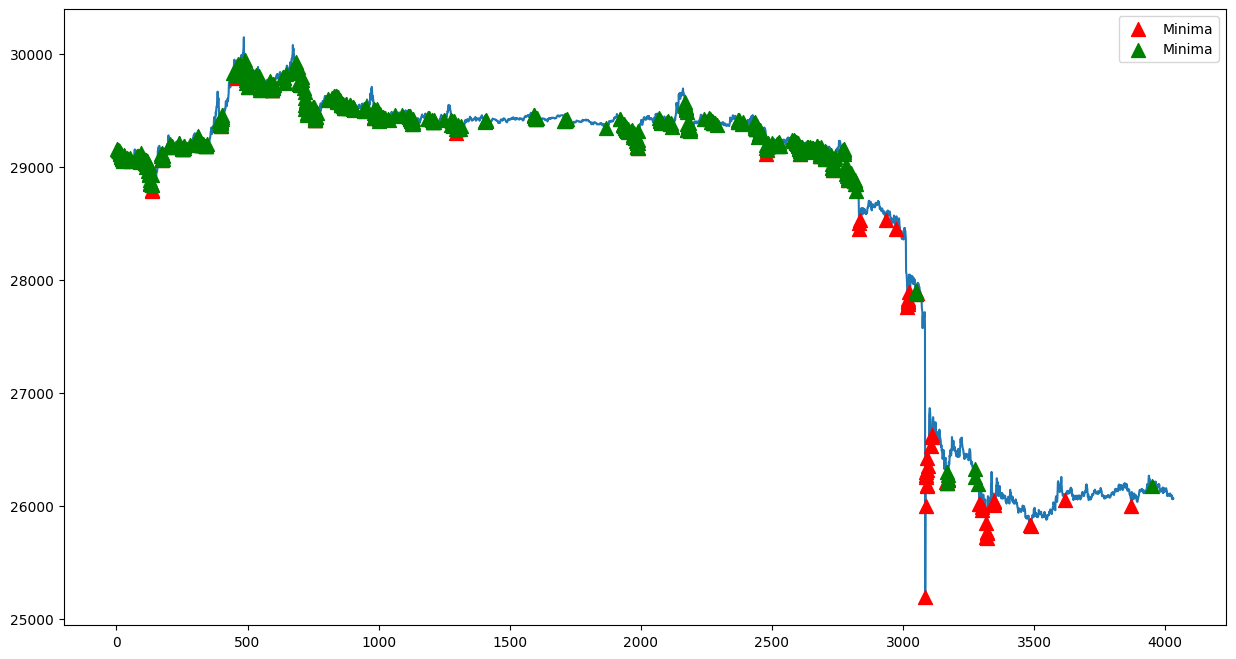

In [23]:
n=2
y_label=pred_direction_test[4032*n:4032*(n+1)]
y_label_true = test_bottoms[4032*n:4032*(n+1)]

index_val = np.where(y_label == 1)
index_val_true = np.where(y_label_true == 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 8))
plt.plot(test_y_slide[4032*n:4032*(n+1)], zorder=0)
plt.scatter(index_val_true[0], test_y_slide[4032*n:4032*(n+1)][np.where(y_label_true == 1)],
  label='Minima', s=100, color='red', marker='^')
plt.scatter(index_val[0], test_y_slide[4032*n:4032*(n+1)][np.where(y_label == 1)],
  label='Minima', s=100, color='green', marker='^')
plt.legend()
plt.show()

In [24]:
xgb_model.save_model(f"{model_save_folder}/BPC_BTC.model")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:03:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Buy  Hold Strategy

In [25]:
def get_profit(pred_direction_test, test_y_tft_cl):
  predictions = torch.squeeze(pred_direction_test)
  indices = torch.nonzero(predictions).flatten()
  close_values = torch.squeeze(test_y_tft_cl[:,classification_label_size,:])
  gained_prof = []
  actual_prof = []
  gained_avg = 0
  actual_avg = 0
  for i in indices:
      entry_point = close_values[i]
      exit_points = close_values[i+1:i+classification_label_size]
      exit_value, exit_index = torch.max(exit_points, dim=0)
      profit_gained = exit_value - entry_point

      intermediate_points = close_values[i:i+1+exit_index]
      best_point,best_point_index = torch.min(intermediate_points,dim=0)
      profit_actual = exit_value - best_point

      gained_prof.append(profit_gained)
      actual_prof.append(profit_actual)
  if len(indices) != 0:
    gained_avg = sum(gained_prof)/len(indices)
    actual_avg = sum(actual_prof)/len(indices)
  return gained_avg, actual_avg, len(indices)

In [26]:
import pandas as pd  # ensure imported
from sklearn.metrics import f1_score, precision_score, recall_score

metrics_rows = []  # collect dicts here

model_xgboost1 = xgb.XGBClassifier()
model_xgboost1.load_model(f"{model_save_folder}/BPC_BTC.model")

for n in range(9):
    idx_slice = slice(4032*n, 4032*(n+1))
    idx_slice_1 = slice(4032*n, 4032*(n+1 + classification_label_size))
    test_input_features_1, pred_test_1 = get_intermediate_weights(test_idx[idx_slice], df)

    # Concatenate additional feature tensors
    test_input_features_1 = torch.cat(
        (test_input_features_1, new_feature_tensor_test[idx_slice]), dim=2
    )
    if include_google_trend:
        test_input_features_1 = torch.cat(
            (test_input_features_1, test_google_trend[idx_slice]), dim=2
        )

    # Run model
    pred_direction_test_1, true_direction_test_1 = xgboost_test(
        test_input_features_1,
        test_bottoms[idx_slice],
        model_xgboost1
    )
    pred_direction_test_1 = torch.round(pred_direction_test_1).long()

    y_true = test_bottoms[idx_slice].cpu().numpy()
    y_pred = pred_direction_test_1.cpu().numpy()

    f1_val = f1_score(y_true, y_pred)  # binary default average
    precision_val = precision_score(y_true, y_pred, zero_division=0)
    recall_val = recall_score(y_true, y_pred, average='micro')  # for binary default pos_label=1

    gained_avg, actual_avg, trades = get_profit(
        pred_direction_test_1,
        test_y_tft_cl[idx_slice_1]
    )

    metrics_rows.append({
        "test_set": n,
        "f1": f1_val,
        "precision": precision_val,
        "recall": recall_val,
        "gained_profit": float(gained_avg),
        "actual_profit": float(actual_avg),
        "trades": int(trades)
    })
    print(f"{n} test set processed")

# Create DataFrame and save
metrics_df = pd.DataFrame(metrics_rows, columns=[
    "test_set", "f1", "precision", "recall", "gained_profit", "actual_profit", "trades"
])

output_csv_path = f"{model_save_folder}/xgb_test_metrics.csv"
metrics_df.to_csv(output_csv_path, index=False)  # writes CSV without index
print(f"Saved metrics to {output_csv_path}")

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

0 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

1 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

2 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

3 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

4 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

5 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

6 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

7 test set processed


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/tmp/ipython-input-18-4127334266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["time_idx"] = chunk.index
/tmp/ipython-input-18-4127334266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a co

8 test set processed
Saved metrics to /content/drive/MyDrive/tft/classifier/model-30-2-GT-False/xgb_test_metrics.csv
